In [1]:
# !pip install pm4py

In [2]:
# sepsis_loading.py
from pathlib import Path
import hashlib, warnings, numpy as np, pandas as pd
import pm4py
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

In [ ]:
def _hash(cols):
    return hashlib.md5(",".join(sorted(cols)).encode()).hexdigest()[:8]

In [ ]:
import pm4py
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer
from collections import defaultdict

def activity_feature_map(xes_path, verbose=True):
    """
    Return a dict: {activity_name: sorted(list_of_attributes_present)}
    """
    xes = Path("datasets/sepsis", "Sepsis Cases - Event Log.xes.gz").expanduser()
    log = xes_importer.apply(str(xes))
    df  = log_converter.apply(log, variant=log_converter.TO_DATA_FRAME)

    # Generic columns that all events share
    GENERIC = {"case:concept:name", "concept:name",
               "time:timestamp", "lifecycle:transition",
               "org:resource", "org:role", "org:group"}

    # Group by activity and collect attribute names that have at least 1 non‑null
    mapping = defaultdict(set)
    for act, g in df.groupby("concept:name"):
        for col in g.columns:
            if col not in GENERIC and g[col].notna().any():
                mapping[act].add(col)

    mapping = {k: sorted(v) for k, v in mapping.items()}
    if verbose:
        for act, cols in sorted(mapping.items(), key=lambda x: x[0]):
            print(f"{act:35s} → {', '.join(cols) or '—'}")

    return mapping

In [45]:
mapping = activity_feature_map("Sepsis Cases - Event Log.xes.gz")

parsing log, completed traces ::   0%|          | 0/1050 [00:00<?, ?it/s]

CRP                                 → Age, CRP, Diagnose
ER Registration                     → Age, Diagnose, DiagnosticArtAstrup, DiagnosticBlood, DiagnosticECG, DiagnosticIC, DiagnosticLacticAcid, DiagnosticLiquor, DiagnosticOther, DiagnosticSputum, DiagnosticUrinaryCulture, DiagnosticUrinarySediment, DiagnosticXthorax, DisfuncOrg, Hypotensie, Hypoxie, InfectionSuspected, Infusion, Oligurie, SIRSCritHeartRate, SIRSCritLeucos, SIRSCritTachypnea, SIRSCritTemperature, SIRSCriteria2OrMore
ER Sepsis Triage                    → Age, Diagnose
ER Triage                           → Age, Diagnose
IV Liquid                           → Age, Diagnose
LacticAcid                          → LacticAcid
Leucocytes                          → Age, Diagnose, Leucocytes


In [167]:
xes = Path("datasets/sepsis", "Sepsis Cases - Event Log.xes.gz").expanduser()
log = xes_importer.apply(str(xes))
df  = log_converter.apply(log, variant=log_converter.TO_DATA_FRAME)
df.rename(columns={"case:concept:name": "case_id",
                    "concept:name"    : "act",
                    "time:timestamp"  : "ts"}, inplace=True)

parsing log, completed traces ::   0%|          | 0/1050 [00:00<?, ?it/s]

In [168]:
cases = df['case_id'].unique()
df_sepsis = pd.DataFrame({'case_id': cases})
admission_data = []
for case_id in cases:
    case_df = df[df['case_id'] == case_id]
    
    # Check for Admission IC
    admission_ic = case_df[case_df['act'] == 'Admission IC']
    # Check for Admission NC
    admission_nc = case_df[case_df['act'] == 'Admission NC']
    
    if not admission_ic.empty:
        admission_type = 'IC'
        admission_ts = admission_ic['ts'].iloc[0]
    elif not admission_nc.empty:
        admission_type = 'NC'
        admission_ts = admission_nc['ts'].iloc[0]
    else:
        admission_type = None
        admission_ts = None
    
    admission_data.append({
        'case_id': case_id,
        'admission_decision': admission_type,
        'admission_ts': admission_ts
    })
# Convert to dataframe and merge with df_sepsis
admission_df = pd.DataFrame(admission_data)
df_sepsis = pd.merge(df_sepsis, admission_df, on='case_id', how='left')
df_sepsis

,case_id,admission_decision,admission_ts
0,A,NC,2014-10-22 14:13:19+00:00
1,B,NC,2014-12-21 13:17:08+00:00
2,C,NC,2014-02-09 22:53:46+00:00
3,D,NC,2014-07-10 14:07:02+00:00
4,E,None,NaT
...,...,...,...
1045,HNA,IC,2014-08-01 12:16:48+00:00
1046,INA,None,NaT
1047,JNA,None,NaT
1048,KNA,NC,2014-12-12 05:06:38+00:00


In [169]:
df_sepsis['admission_decision'].value_counts(normalize=1)

NC    0.864198
IC    0.135802
Name: admission_decision, dtype: float64

In [170]:
activity_sequences = {}
for case_id, case_df in df.groupby('case_id'):
    case_df = case_df.sort_values('ts')
    first_admission = case_df[case_df['act'].isin(['Admission IC', 'Admission NC'])]
    
    if not first_admission.empty:
        first_admission_ts = first_admission['ts'].iloc[0]
        pre_admission_acts = sorted(case_df[case_df['ts'] < first_admission_ts]['act'].tolist())
    else:
        pre_admission_acts = sorted(case_df['act'].tolist())
    
    activity_sequences[case_id] = ','.join(pre_admission_acts)

# If you want to store the actual sequence instead of a hash
df_sepsis['pre_admission_sequence'] = df_sepsis['case_id'].map(activity_sequences)

In [171]:
df_sepsis['pre_admission_sequence'].value_counts(dropna=0,normalize=1)[:10]

CRP,ER Registration,ER Sepsis Triage,ER Triage,IV Antibiotics,IV Liquid,LacticAcid,Leucocytes                   0.619048
CRP,ER Registration,ER Sepsis Triage,ER Triage,Leucocytes                                                       0.103810
CRP,ER Registration,ER Sepsis Triage,ER Triage,IV Antibiotics,LacticAcid,Leucocytes                             0.075238
CRP,ER Registration,ER Sepsis Triage,ER Triage,LacticAcid,Leucocytes                                            0.065714
ER Registration,ER Sepsis Triage,ER Triage                                                                      0.036190
CRP,ER Registration,ER Sepsis Triage,ER Triage,IV Antibiotics,IV Liquid,Leucocytes                              0.024762
CRP,CRP,ER Registration,ER Sepsis Triage,ER Triage,IV Antibiotics,IV Liquid,LacticAcid,Leucocytes,Leucocytes    0.013333
CRP,ER Registration,ER Sepsis Triage,ER Triage,IV Antibiotics,Leucocytes                                        0.010476
CRP,ER Registration,ER Sepsis Tr

In [178]:
def extract_pre_admission_variables_with_values(df):
    """
    Extract all variables before admission with their values, 
    numbering repeated measurements sequentially
    """
    admission_acts = ['Admission IC', 'Admission NC']
    pre_admission_data = {}
    
    for case_id, case_df in df.groupby('case_id'):
        # Sort by timestamp
        case_df = case_df.sort_values('ts')
        
        # Find first admission decision (if any)
        first_admission = case_df[case_df['act'].isin(admission_acts)]
        
        if not first_admission.empty:
            # Get the timestamp of first admission
            first_admission_ts = first_admission['ts'].iloc[0]
            
            # Get all events before this timestamp
            pre_admission_events = case_df[case_df['ts'] < first_admission_ts]
        else:
            # If no admission, use all events
            pre_admission_events = case_df
        
        # Dictionary to track how many times we've seen each variable
        var_counts = {}
        
        # Dictionary to store the variables and their values
        case_variables = {}
        
        # Go through events in chronological order
        for _, row in pre_admission_events.iterrows():
            # Get all columns that have non-null values
            for col in df.columns:
                if col not in ['case_id', 'act', 'ts', 'lifecycle:transition','org:group'] and not pd.isna(row[col]):
                    # Count occurrences of this variable
                    var_counts[col] = var_counts.get(col, 0) + 1
                    
                    # Create variable name with sequence number
                    var_name = f"{col}_{var_counts[col]}" if var_counts[col] > 1 else col
                    
                    # Store the variable and its value
                    case_variables[var_name] = row[col]
        
        # Store variables for this case
        pre_admission_data[case_id] = sorted(case_variables)
    
    return pre_admission_data


In [179]:
pre_admission_vars = extract_pre_admission_variables_with_values(df)

In [180]:
pre_admission_vars

{'A': ['Age',
  'CRP',
  'Diagnose',
  'DiagnosticArtAstrup',
  'DiagnosticBlood',
  'DiagnosticECG',
  'DiagnosticIC',
  'DiagnosticLacticAcid',
  'DiagnosticLiquor',
  'DiagnosticOther',
  'DiagnosticSputum',
  'DiagnosticUrinaryCulture',
  'DiagnosticUrinarySediment',
  'DiagnosticXthorax',
  'DisfuncOrg',
  'Hypotensie',
  'Hypoxie',
  'InfectionSuspected',
  'Infusion',
  'LacticAcid',
  'Leucocytes',
  'Oligurie',
  'SIRSCritHeartRate',
  'SIRSCritLeucos',
  'SIRSCritTachypnea',
  'SIRSCritTemperature',
  'SIRSCriteria2OrMore'],
 'AA': ['Age',
  'CRP',
  'DiagnosticArtAstrup',
  'DiagnosticBlood',
  'DiagnosticECG',
  'DiagnosticIC',
  'DiagnosticLacticAcid',
  'DiagnosticLiquor',
  'DiagnosticOther',
  'DiagnosticSputum',
  'DiagnosticUrinaryCulture',
  'DiagnosticUrinarySediment',
  'DiagnosticXthorax',
  'DisfuncOrg',
  'Hypotensie',
  'Hypoxie',
  'InfectionSuspected',
  'Infusion',
  'LacticAcid',
  'Leucocytes',
  'Oligurie',
  'SIRSCritHeartRate',
  'SIRSCritLeucos',
  'SI

In [181]:
df_sepsis['pre_admission_variables'] = df_sepsis['case_id'].map(
    lambda x: ','.join(pre_admission_vars.get(x, []))
)

In [182]:
df_sepsis['pre_admission_variables'].value_counts(dropna=0, normalize=1)

Age,CRP,Diagnose,DiagnosticArtAstrup,DiagnosticBlood,DiagnosticECG,DiagnosticIC,DiagnosticLacticAcid,DiagnosticLiquor,DiagnosticOther,DiagnosticSputum,DiagnosticUrinaryCulture,DiagnosticUrinarySediment,DiagnosticXthorax,DisfuncOrg,Hypotensie,Hypoxie,InfectionSuspected,Infusion,LacticAcid,Leucocytes,Oligurie,SIRSCritHeartRate,SIRSCritLeucos,SIRSCritTachypnea,SIRSCritTemperature,SIRSCriteria2OrMore                                                 0.620000
Age,CRP,DiagnosticArtAstrup,DiagnosticBlood,DiagnosticECG,DiagnosticIC,DiagnosticLacticAcid,DiagnosticLiquor,DiagnosticOther,DiagnosticSputum,DiagnosticUrinaryCulture,DiagnosticUrinarySediment,DiagnosticXthorax,DisfuncOrg,Hypotensie,Hypoxie,InfectionSuspected,Infusion,LacticAcid,Leucocytes,Oligurie,SIRSCritHeartRate,SIRSCritLeucos,SIRSCritTachypnea,SIRSCritTemperature,SIRSCriteria2OrMore                                                          0.115238
Age,CRP,Diagnose,DiagnosticArtAstrup,DiagnosticBlood,DiagnosticECG,DiagnosticIC,Diagno

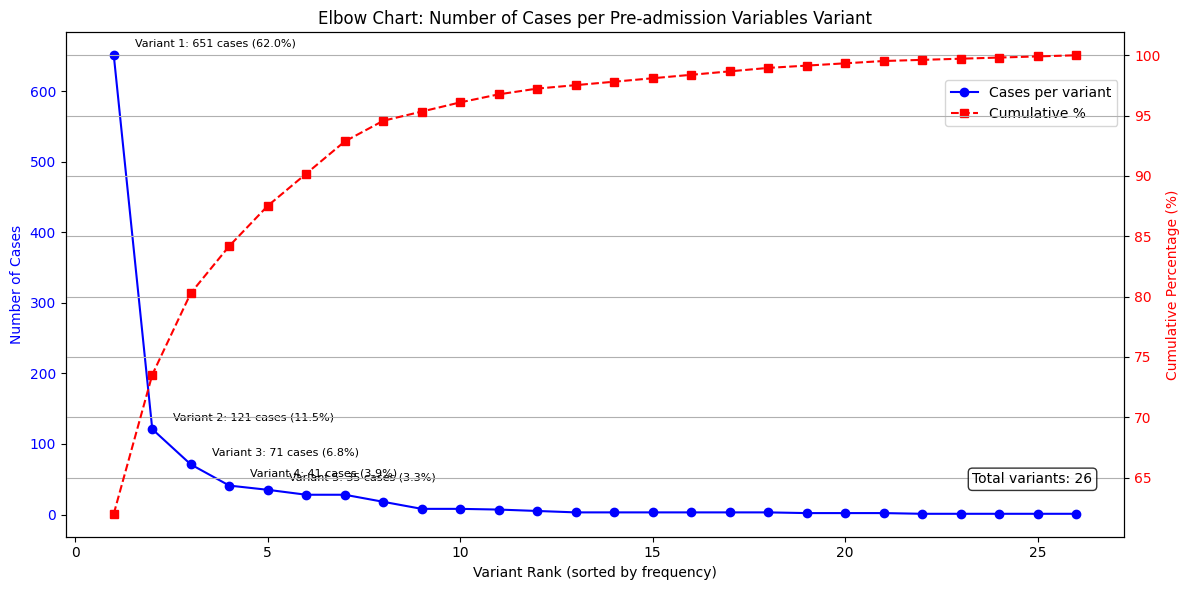

Total number of variants: 26
Most common variant has 651 cases (62.00%)
Top 5 variants cover 919 cases out of 1050 total cases (87.52%)
Number of variants needed to cover 80% of cases: 3


In [187]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# Count how many cases have each unique combination of pre-admission variables
variant_counts = Counter()
for case_id, variables in pre_admission_vars.items():
    # Create a variant ID using hash function 
    variant_id = _hash(variables)
    variant_counts[variant_id] += 1

# Sort variants by frequency (descending)
sorted_variants = sorted(variant_counts.items(), key=lambda x: x[1], reverse=True)

# Extract the counts only
counts = [count for _, count in sorted_variants]

# Calculate cumulative sum and percentage
cumulative_counts = np.cumsum(counts)
total_cases = sum(counts)
cumulative_percentage = 100 * cumulative_counts / total_cases

# Create elbow chart with dual y-axis
fig, ax1 = plt.figure(figsize=(12, 6)), plt.gca()

# Plot the elbow chart (number of cases per variant)
line1 = ax1.plot(range(1, len(counts) + 1), counts, marker='o', linestyle='-', color='blue', label='Cases per variant')
ax1.set_xlabel('Variant Rank (sorted by frequency)')
ax1.set_ylabel('Number of Cases', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create second y-axis for cumulative percentage
ax2 = ax1.twinx()
line2 = ax2.plot(range(1, len(counts) + 1), cumulative_percentage, marker='s', linestyle='--', color='red', label='Cumulative %')
ax2.set_ylabel('Cumulative Percentage (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.grid(True)

# Add a title
plt.title('Elbow Chart: Number of Cases per Pre-admission Variables Variant')

# Add a legend - positioning it a bit lower
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='lower right', bbox_to_anchor=(1, 0.8))

# Add a text showing total number of variants
plt.text(0.97, 0.1, f'Total variants: {len(counts)}', 
         transform=plt.gca().transAxes, ha='right', va='bottom', 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Add annotations for the top 5 variants with smaller font size
for i in range(min(5, len(counts))):
    ax1.annotate(f'Variant {i+1}: {counts[i]} cases ({(counts[i]/total_cases*100):.1f}%)', 
                xy=(i+1, counts[i]+3),
                xytext=(15, 7), textcoords='offset points',
                va='center', fontsize=8)

plt.tight_layout()
plt.show()

# Display statistics
print(f"Total number of variants: {len(counts)}")
print(f"Most common variant has {counts[0]} cases ({counts[0]/total_cases*100:.2f}%)")
print(f"Top 5 variants cover {cumulative_counts[4]} cases out of {total_cases} total cases ({cumulative_percentage[4]:.2f}%)")
# Find how many variants needed to cover 80% of cases
variants_for_80_percent = np.argmax(cumulative_percentage >= 80) + 1  # +1 because indices start at 0
print(f"Number of variants needed to cover 80% of cases: {variants_for_80_percent}")


In [ ]:
T_ACTIVITY = "admission_decision"   # primary treatment

In [ ]:
# Create a feature extraction function to get all values before admission for each case
def extract_pre_admission_features(df, df_sepsis):
    """
    Extract all features from events before admission timestamp for each case_id.
    If multiple values exist for a column, create numbered columns (_2, _3, etc.)
    """
    # Initialize an empty dataframe to store results
    result_df = pd.DataFrame(index=df_sepsis['case_id'].unique())
    
    # Get all possible feature columns (excluding metadata columns)
    feature_cols = [col for col in df.columns if col not in ['case_id', 'act', 'ts', 
                                                             'lifecycle:transition', 'org:group']]
    
    # Process each case
    for case_id in df_sepsis['case_id'].unique():
        # Get admission timestamp for this case
        admission_ts = df_sepsis.loc[df_sepsis['case_id'] == case_id, 'admission_ts'].iloc[0] \
                        if not df_sepsis.loc[df_sepsis['case_id'] == case_id, 'admission_ts'].isna().iloc[0] else None
        
        # Get all events for this case
        case_events = df[df['case_id'] == case_id]
        
        # If admission timestamp exists, filter events before admission
        if admission_ts is not None:
            case_events = case_events[case_events['ts'] < admission_ts]
        
        # Sort by timestamp to process events chronologically
        case_events = case_events.sort_values('ts')
        
        # Store activity sequence before admission
        result_df.at[case_id, 'pre_admission_activities'] = ','.join(case_events['act'].tolist())
        
        # Process each feature column
        for col in feature_cols:
            # Track how many times we've seen this column
            col_count = 0
            
            # Go through events in chronological order
            for _, row in case_events.iterrows():
                # If column has a non-null value
                if not pd.isna(row[col]):
                    col_count += 1
                    # Create column name with suffix if needed
                    col_name = f"{col}_{col_count}" if col_count > 1 else col
                    # Store the value
                    result_df.at[case_id, col_name] = row[col]
    
    # Reset index to get case_id as a column
    result_df = result_df.reset_index().rename(columns={'index': 'case_id'})
    
    return result_df

# Extract pre-admission features
pre_admission_features = extract_pre_admission_features(df, df_sepsis)

# Merge with existing df_sepsis to add the new features
df_sepsis_extended = pd.merge(df_sepsis, pre_admission_features, on='case_id', how='left')

# Display the first few rows of the enhanced dataframe
df_sepsis_extended.head()


,case_id,admission_decision,admission_ts,pre_admission_sequence,pre_admission_variables,pre_admission_activities,InfectionSuspected,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,...,CRP_10,CRP_11,CRP_12,CRP_13,CRP_14,CRP_15,CRP_16,CRP_17,CRP_18,CRP_19
0,A,NC,2014-10-22 14:13:19+00:00,"CRP,ER Registration,ER Sepsis Triage,ER Triage...","Age,CRP,Diagnose,DiagnosticArtAstrup,Diagnosti...","ER Registration,Leucocytes,CRP,LacticAcid,ER T...",True,True,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,B,NC,2014-12-21 13:17:08+00:00,"CRP,ER Registration,ER Sepsis Triage,ER Triage...","Age,CRP,Diagnose,DiagnosticArtAstrup,Diagnosti...","ER Registration,ER Triage,CRP,LacticAcid,Leuco...",True,True,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C,NC,2014-02-09 22:53:46+00:00,"CRP,ER Registration,ER Sepsis Triage,ER Triage...","Age,CRP,Diagnose,DiagnosticArtAstrup,Diagnosti...","ER Registration,ER Triage,ER Sepsis Triage,Leu...",True,True,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,D,NC,2014-07-10 14:07:02+00:00,"CRP,ER Registration,ER Sepsis Triage,ER Triage...","Age,CRP,Diagnose,DiagnosticArtAstrup,Diagnosti...","ER Registration,ER Triage,ER Sepsis Triage,CRP...",True,True,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E,None,NaT,"CRP,ER Registration,ER Sepsis Triage,ER Triage...","Age,CRP,DiagnosticArtAstrup,DiagnosticBlood,Di...","ER Registration,ER Triage,ER Sepsis Triage,IV ...",True,True,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [193]:
df_sepsis_extended[df_sepsis_extended['CRP_18'].notna()]

,case_id,admission_decision,admission_ts,pre_admission_sequence,pre_admission_variables,pre_admission_activities,InfectionSuspected,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,...,CRP_10,CRP_11,CRP_12,CRP_13,CRP_14,CRP_15,CRP_16,CRP_17,CRP_18,CRP_19
291,GK,IC,2015-01-18 14:30:00+00:00,"CRP,CRP,ER Registration,ER Sepsis Triage,ER Tr...","Age,CRP,CRP_2,Diagnose,DiagnosticArtAstrup,Dia...","Leucocytes,CRP,ER Registration,ER Triage,ER Se...",True,True,False,False,...,131.0,110.0,82.0,61.0,35.0,29.0,31.0,41.0,56.0,119.0


In [ ]:
# Load the event log data from XES file
xes = Path("datasets/sepsis", "Sepsis Cases - Event Log.xes.gz").expanduser()
log = xes_importer.apply(str(xes))
df = log_converter.apply(log, variant=log_converter.TO_DATA_FRAME)
df.rename(columns={"case:concept:name": "case_id",
                   "concept:name": "act",
                   "time:timestamp": "ts"}, inplace=True)

# Create a new df_sepsis dataframe with case-level features
cases = df['case_id'].unique()
df_sepsis = pd.DataFrame({'case_id': cases})

# Create a feature for admission type (NC or IC) with timestamp
admission_data = []
for case_id in cases:
    case_df = df[df['case_id'] == case_id]
    
    # Check for Admission IC
    admission_ic = case_df[case_df['act'] == 'Admission IC']
    # Check for Admission NC
    admission_nc = case_df[case_df['act'] == 'Admission NC']
    
    if not admission_ic.empty:
        admission_type = 'IC'
        admission_ts = admission_ic['ts'].iloc[0]
    elif not admission_nc.empty:
        admission_type = 'NC'
        admission_ts = admission_nc['ts'].iloc[0]
    else:
        admission_type = None
        admission_ts = None
    
    admission_data.append({
        'case_id': case_id,
        'admission_type': admission_type,
        'admission_ts': admission_ts
    })

# Convert to dataframe and merge with df_sepsis
admission_df = pd.DataFrame(admission_data)
df_sepsis = pd.merge(df_sepsis, admission_df, on='case_id', how='left')

# Add other important features (like treatment times, lab values, etc)
# Find first IV Antibiotics time for each case (treatment time)
first_abx = df[df['act'] == T_ACTIVITY].sort_values('ts').groupby('case_id')['ts'].first()
df_sepsis = df_sepsis.join(first_abx.rename('treatment_time'), on='case_id')

# Calculate if treatment was applied early (within EARLY_WINDOW_HOURS)
df_sepsis['T'] = 0  # Default is not early

# Only calculate for cases with both admission and treatment
mask = (~df_sepsis['admission_ts'].isna()) & (~df_sepsis['treatment_time'].isna())
df_sepsis.loc[mask, 'T'] = (
    (df_sepsis.loc[mask, 'treatment_time'] - df_sepsis.loc[mask, 'admission_ts']).dt.total_seconds() <= EARLY_WINDOW_HOURS * HOURS
).astype(int)

# Add variant information for process mining
df_sepsis['variant'] = df.groupby('case_id')['act'].apply(lambda x: _hash(x.tolist()))

# Add other useful case-level features
# Count each activity type per case
activities = df['act'].unique()
for activity in activities:
    counts = df[df['act'] == activity].groupby('case_id').size()
    df_sepsis[f'cnt_{activity}'] = df_sepsis['case_id'].map(counts).fillna(0).astype(int)

# Add last activity per case
last_acts = df.sort_values('ts').groupby('case_id')['act'].last()
activity_to_id = {act: i for i, act in enumerate(sorted(df['act'].unique()))}
df_sepsis['last_act'] = df_sepsis['case_id'].map(last_acts).map(activity_to_id).astype('int8')

# Add lab measurements (first, last, min, max values)
for lab in ['CRP', 'LacticAcid', 'Leucocytes']:
    # Get measurements for this lab test
    lab_df = df[df['act'] == lab].dropna(subset=[lab])
    
    # Calculate first, last, min, max values per case
    if not lab_df.empty:
        first_vals = lab_df.sort_values('ts').groupby('case_id')[lab].first()
        last_vals = lab_df.sort_values('ts').groupby('case_id')[lab].last()
        max_vals = lab_df.groupby('case_id')[lab].max()
        min_vals = lab_df.groupby('case_id')[lab].min()
        
        # Add to df_sepsis
        df_sepsis[f'first_{lab}'] = df_sepsis['case_id'].map(first_vals)
        df_sepsis[f'last_{lab}'] = df_sepsis['case_id'].map(last_vals)
        df_sepsis[f'max_{lab}'] = df_sepsis['case_id'].map(max_vals)
        df_sepsis[f'min_{lab}'] = df_sepsis['case_id'].map(min_vals)

# Calculate outcome variable Y (time from admission to release)
release_acts = ['Release A', 'Release B', 'Release C', 'Release D', 'Release E']
release_times = {}

for case_id in cases:
    case_df = df[df['case_id'] == case_id]
    
    # Find all release activities for this case
    case_releases = case_df[case_df['act'].isin(release_acts)]
    
    if not case_releases.empty:
        # Get the first release time
        release_time = case_releases['ts'].min()
        
        # Get admission time
        if not df_sepsis.loc[df_sepsis['case_id'] == case_id, 'admission_ts'].isna().values[0]:
            admission_time = df_sepsis.loc[df_sepsis['case_id'] == case_id, 'admission_ts'].values[0]
            
            # Convert timestamps to pandas Timestamp objects if they're numpy.datetime64
            if isinstance(admission_time, np.datetime64):
                admission_time = pd.Timestamp(admission_time)
            if isinstance(release_time, np.datetime64):
                release_time = pd.Timestamp(release_time)
            
            # Make sure both timestamps have the same timezone information
            if hasattr(admission_time, 'tzinfo') and hasattr(release_time, 'tzinfo'):
                if admission_time.tzinfo is None and release_time.tzinfo is not None:
                    admission_time = admission_time.replace(tzinfo=release_time.tzinfo)
                elif release_time.tzinfo is None and admission_time.tzinfo is not None:
                    release_time = release_time.replace(tzinfo=admission_time.tzinfo)
            
            # Calculate duration in hours
            duration = (release_time - admission_time).total_seconds() / HOURS
            release_times[case_id] = duration

# Add to df_sepsis
df_sepsis['Y'] = df_sepsis['case_id'].map(release_times)

# Fill missing Y values with median for cases without release
if 'Y' in df_sepsis.columns:
    median_y = df_sepsis['Y'].median()
    df_sepsis['Y'] = df_sepsis['Y'].fillna(median_y)

In [49]:
df_sepsis

,case_id,admission_type,admission_ts,treatment_time,T,variant,cnt_ER Registration,cnt_Leucocytes,cnt_CRP,cnt_LacticAcid,...,min_CRP,first_LacticAcid,last_LacticAcid,max_LacticAcid,min_LacticAcid,first_Leucocytes,last_Leucocytes,max_Leucocytes,min_Leucocytes,Y
0,A,NC,2014-10-22 14:13:19+00:00,2014-10-22 14:03:47+00:00,1,NaN,1,7,7,1,...,6.0,2.2,2.2,2.2,2.2,9.6,10.9,13.0,8.7,265.028056
1,B,NC,2014-12-21 13:17:08+00:00,2014-12-21 12:33:55+00:00,1,NaN,1,1,3,1,...,75.0,0.8,0.8,0.8,0.8,13.8,13.8,13.8,13.8,124.714444
2,C,NC,2014-02-09 22:53:46+00:00,2014-02-09 20:07:19+00:00,1,NaN,1,3,3,0,...,27.0,NaN,NaN,NaN,NaN,15.4,7.4,18.1,7.4,131.103889
3,D,NC,2014-07-10 14:07:02+00:00,2014-07-10 12:57:05+00:00,1,NaN,1,2,2,1,...,49.0,1.6,1.6,1.6,1.6,7.7,7.6,7.7,7.6,123.882778
4,E,None,NaT,2015-01-15 20:35:59+00:00,0,NaN,1,1,1,1,...,265.0,2.8,2.8,2.8,2.8,8.5,8.5,8.5,8.5,129.698333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,HNA,IC,2014-08-01 12:16:48+00:00,2014-08-01 12:15:29+00:00,1,NaN,1,8,9,6,...,52.0,7.2,1.4,7.2,1.4,2.0,12.0,18.3,1.8,286.220000
1046,INA,None,NaT,NaT,0,NaN,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129.698333
1047,JNA,None,NaT,NaT,0,NaN,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129.698333
1048,KNA,NC,2014-12-12 05:06:38+00:00,2014-12-12 05:03:43+00:00,1,NaN,1,3,3,2,...,66.0,2.3,0.2,2.3,0.2,9.4,8.9,9.4,8.5,107.889444


In [43]:
for t in df.columns:
    display(df[t].value_counts())

True     848
False    202
Name: InfectionSuspected, dtype: int64

B    8111
A    3462
C    1053
E     782
?     294
F     216
L     213
O     186
G     148
I     126
M      84
Q      63
P      59
R      57
H      55
W      55
D      47
N      46
T      35
S      33
J      26
V      25
K      18
U      18
X       1
Y       1
Name: org:group, dtype: int64

True     823
False    227
Name: DiagnosticBlood, dtype: int64

False    981
True      69
Name: DisfuncOrg, dtype: int64

True     601
False    449
Name: SIRSCritTachypnea, dtype: int64

False    996
True      54
Name: Hypotensie, dtype: int64

True     811
False    239
Name: SIRSCritHeartRate, dtype: int64

True     796
False    254
Name: Infusion, dtype: int64

False    753
True     297
Name: DiagnosticArtAstrup, dtype: int64

Leucocytes          3383
CRP                 3262
LacticAcid          1466
Admission NC        1182
ER Triage           1053
ER Registration     1050
ER Sepsis Triage    1049
IV Antibiotics       823
IV Liquid            753
Release A            671
Return ER            294
Admission IC         117
Release B             56
Release C             25
Release D             24
Release E              6
Name: act, dtype: int64

90.0    155
85.0    149
75.0    135
80.0    129
70.0    110
65.0     78
60.0     71
55.0     60
50.0     36
45.0     28
35.0     28
40.0     23
25.0     19
30.0     18
20.0     11
Name: Age, dtype: int64

True     848
False    202
Name: DiagnosticIC, dtype: int64

False    1021
True       29
Name: DiagnosticSputum, dtype: int64

False    1045
True        5
Name: DiagnosticLiquor, dtype: int64

False    1040
True       10
Name: DiagnosticOther, dtype: int64

True     853
False    197
Name: SIRSCriteria2OrMore, dtype: int64

True     785
False    265
Name: DiagnosticXthorax, dtype: int64

True     801
False    249
Name: SIRSCritTemperature, dtype: int64

2014-08-25 08:00:00+00:00    17
2014-04-20 09:00:00+00:00    16
2014-08-30 08:00:00+00:00    14
2014-08-05 08:00:00+00:00    14
2014-06-07 08:00:00+00:00    14
                             ..
2014-01-18 10:58:31+00:00     1
2014-01-17 14:40:00+00:00     1
2014-01-14 15:00:00+00:00     1
2014-01-14 04:06:33+00:00     1
2014-12-03 10:54:39+00:00     1
Name: ts, Length: 9469, dtype: int64

False    574
True     476
Name: DiagnosticUrinaryCulture, dtype: int64

False    1001
True       49
Name: SIRSCritLeucos, dtype: int64

False    1025
True       25
Name: Oligurie, dtype: int64

True     804
False    246
Name: DiagnosticLacticAcid, dtype: int64

complete    15214
Name: lifecycle:transition, dtype: int64

C     147
B      82
E      67
H      51
G      44
     ... 
GC      1
FC      1
EC      1
DC      1
QE      1
Name: Diagnose, Length: 146, dtype: int64

False    1030
True       20
Name: Hypoxie, dtype: int64

False    531
True     519
Name: DiagnosticUrinarySediment, dtype: int64

True     765
False    285
Name: DiagnosticECG, dtype: int64

NGA    185
KM     170
OD     118
GK      88
YX      84
      ... 
OF       3
MF       3
HMA      3
FFA      3
LNA      3
Name: case_id, Length: 1050, dtype: int64

11.4     37
10.1     35
9.8      34
10.4     33
8.7      33
         ..
71.8      1
33.8      1
28.6      1
381.3     1
36.9      1
Name: Leucocytes, Length: 360, dtype: int64

17.0     34
8.0      31
19.0     29
20.0     28
11.0     28
         ..
333.0     1
351.0     1
378.0     1
309.0     1
358.0     1
Name: CRP, Length: 371, dtype: int64

1.2     86
1.1     84
1.3     82
1.4     77
1.5     75
        ..
8.3      1
10.0     1
9.7      1
6.7      1
7.2      1
Name: LacticAcid, Length: 79, dtype: int64

In [39]:
df[df['act']=='ER Triage']['Diagnose'].value_counts()

S    1
Q    1
B    1
G    1
Name: Diagnose, dtype: int64

In [ ]:
# Get initial patient features from ER Registration
er_registration = df[df['act'] == 'ER Registration'].set_index('case_id')

# Select potentially useful columns from ER Registration
initial_features = [
    'Age', 'InfectionSuspected', 'DiagnosticBlood', 'DisfuncOrg', 
    'SIRSCritTachypnea', 'Hypotensie', 'SIRSCritHeartRate', 
    'SIRSCritTemperature', 'SIRSCriteria2OrMore', 'SIRSCritLeucos',
    'DiagnosticArtAstrup', 'DiagnosticOther', 'DiagnosticXthorax',
    'DiagnosticLacticAcid', 'DiagnosticUrinaryCulture', 'Oligurie', 
    'Hypoxie', 'DiagnosticUrinarySediment', 'DiagnosticECG'
]

# Extract initial features from ER Registration
initial_df = er_registration[initial_features].copy()

# Convert boolean strings to actual booleans
for col in initial_df.columns:
    if initial_df[col].dtype == 'object' and set(initial_df[col].dropna().unique()).issubset({'True', 'False'}):
        initial_df[col] = initial_df[col].map({'True': 1, 'False': 0})

# Get features available before IV Antibiotics for each case
features_before_treatment = {}

# Find first IV Antibiotics time for each case
first_abx = df[df['act'] == T_ACTIVITY].sort_values('ts').groupby('case_id')['ts'].first()

# Join to main dataframe 
df_with_treatment = df.join(first_abx.rename('treatment_time'), on='case_id')

# For each case, get all unique activities performed before treatment
for case_id, case_df in df_with_treatment.groupby('case_id'):
    # Filter events before the treatment (or all events if no treatment time)
    before_treatment = case_df[case_df['ts'] < case_df['treatment_time'].iloc[0]] if not pd.isna(case_df['treatment_time'].iloc[0]) else case_df
    
    # Get all lab measurements available before treatment
    features_before_treatment[case_id] = {
        'activities': list(before_treatment['act'].unique()),
        'measurements': {
            'CRP': before_treatment[before_treatment['act'] == 'CRP']['CRP'].tolist(),
            'Leucocytes': before_treatment[before_treatment['act'] == 'Leucocytes']['Leucocytes'].tolist(),
            'LacticAcid': before_treatment[before_treatment['act'] == 'LacticAcid']['LacticAcid'].tolist()
        }
    }

# Add count of activities before treatment
activity_counts = {}
for case_id, info in features_before_treatment.items():
    for act in df['act'].unique():
        if act not in activity_counts:
            activity_counts[act] = {}
        activity_counts[act][case_id] = info['activities'].count(act)

# Create a dataframe from activity counts
activity_counts_df = pd.DataFrame(activity_counts).fillna(0)

# Add lab measurement features
for measure in ['CRP', 'Leucocytes', 'LacticAcid']:
    # First measurement (or NaN if not available)
    activity_counts_df[f'first_{measure}'] = [
        features_before_treatment[case_id]['measurements'][measure][0] 
        if features_before_treatment[case_id]['measurements'][measure] else np.nan 
        for case_id in activity_counts_df.index
    ]
    
    # Last measurement (or NaN if not available)
    activity_counts_df[f'last_{measure}'] = [
        features_before_treatment[case_id]['measurements'][measure][-1] 
        if features_before_treatment[case_id]['measurements'][measure] else np.nan 
        for case_id in activity_counts_df.index
    ]

# Combine with initial features
ml_ready_df = pd.merge(initial_df, activity_counts_df, left_index=True, right_index=True, how='outer')

# Add target variables
# 1. Treatment applied early (T)
ml_ready_df = ml_ready_df.join(df_sepsis[['case_id', 'T', 'Y']].set_index('case_id'))

# Reset index to get case_id as a column
ml_ready_df = ml_ready_df.reset_index()

# Display the result
print(f"Prepared dataframe with {ml_ready_df.shape[0]} cases and {ml_ready_df.shape[1]} features")
ml_ready_df.head()

Prepared dataframe with 1050 cases and 44 features


,index,Age,InfectionSuspected,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,SIRSCritTemperature,SIRSCriteria2OrMore,...,Release D,Release E,first_CRP,last_CRP,first_Leucocytes,last_Leucocytes,first_LacticAcid,last_LacticAcid,T,Y
0,A,85.0,True,True,True,True,True,True,True,True,...,0,0,21.0,21.0,9.6,9.6,2.2,2.2,1,267.988611
1,AA,75.0,True,True,False,True,False,True,True,True,...,0,0,23.0,23.0,8.6,8.6,1.4,1.4,0,5.354722
2,AAA,60.0,False,True,False,False,False,True,True,True,...,0,0,68.0,68.0,20.8,20.8,2.4,2.4,1,228.982222
3,AB,90.0,True,True,False,True,False,True,True,True,...,0,0,48.0,48.0,15.7,15.7,1.3,1.3,0,3.939722
4,ABA,75.0,True,True,False,False,False,True,True,True,...,0,0,78.0,78.0,2.0,2.0,2.1,2.1,1,148.876667


In [ ]:
# Get initial patient features from ER Registration
er_registration = df[df['act'] == 'ER Registration'].set_index('case_id')

# Select potentially useful columns from ER Registration
initial_features = [
    'Age', 'InfectionSuspected', 'DiagnosticBlood', 'DisfuncOrg', 
    'SIRSCritTachypnea', 'Hypotensie', 'SIRSCritHeartRate', 
    'SIRSCritTemperature', 'SIRSCriteria2OrMore', 'SIRSCritLeucos',
    'DiagnosticArtAstrup', 'DiagnosticOther', 'DiagnosticXthorax',
    'DiagnosticLacticAcid', 'DiagnosticUrinaryCulture', 'Oligurie', 
    'Hypoxie', 'DiagnosticUrinarySediment', 'DiagnosticECG'
]

# Extract initial features from ER Registration
initial_df = er_registration[initial_features].copy()

# Convert boolean strings to actual booleans
for col in initial_df.columns:
    if initial_df[col].dtype == 'object' and set(initial_df[col].dropna().unique()).issubset({'True', 'False'}):
        initial_df[col] = initial_df[col].map({'True': 1, 'False': 0})

# Get features available before IV Antibiotics for each case
features_before_treatment = {}

# Find first IV Antibiotics time for each case
first_abx = df[df['act'] == T_ACTIVITY].sort_values('ts').groupby('case_id')['ts'].first()

# Join to main dataframe 
df_with_treatment = df.join(first_abx.rename('treatment_time'), on='case_id')

# For each case, get all unique activities performed before treatment
for case_id, case_df in df_with_treatment.groupby('case_id'):
    # Filter events before the treatment (or all events if no treatment time)
    before_treatment = case_df[case_df['ts'] < case_df['treatment_time'].iloc[0]] if not pd.isna(case_df['treatment_time'].iloc[0]) else case_df
    
    # Get all lab measurements available before treatment
    features_before_treatment[case_id] = {
        'activities': list(before_treatment['act'].unique()),
        'measurements': {
            'CRP': before_treatment[before_treatment['act'] == 'CRP']['CRP'].tolist(),
            'Leucocytes': before_treatment[before_treatment['act'] == 'Leucocytes']['Leucocytes'].tolist(),
            'LacticAcid': before_treatment[before_treatment['act'] == 'LacticAcid']['LacticAcid'].tolist()
        }
    }

# Add count of activities before treatment
activity_counts = {}
for case_id, info in features_before_treatment.items():
    for act in df['act'].unique():
        if act not in activity_counts:
            activity_counts[act] = {}
        activity_counts[act][case_id] = info['activities'].count(act)

# Create a dataframe from activity counts
activity_counts_df = pd.DataFrame(activity_counts).fillna(0)

# Add lab measurement features
for measure in ['CRP', 'Leucocytes', 'LacticAcid']:
    # First measurement (or NaN if not available)
    activity_counts_df[f'first_{measure}'] = [
        features_before_treatment[case_id]['measurements'][measure][0] 
        if features_before_treatment[case_id]['measurements'][measure] else np.nan 
        for case_id in activity_counts_df.index
    ]
    
    # Last measurement (or NaN if not available)
    activity_counts_df[f'last_{measure}'] = [
        features_before_treatment[case_id]['measurements'][measure][-1] 
        if features_before_treatment[case_id]['measurements'][measure] else np.nan 
        for case_id in activity_counts_df.index
    ]

# Combine with initial features
ml_ready_df = pd.merge(initial_df, activity_counts_df, left_index=True, right_index=True, how='outer')

# Add target variables
# 1. Treatment applied early (T)
ml_ready_df = ml_ready_df.join(df_sepsis[['case_id', 'T', 'Y']].set_index('case_id'))

# Reset index to get case_id as a column
ml_ready_df = ml_ready_df.reset_index()

# Display the result
print(f"Prepared dataframe with {ml_ready_df.shape[0]} cases and {ml_ready_df.shape[1]} features")
ml_ready_df.head()

In [23]:
df_sepsis

,case_id,variant,cnt_Admission IC,cnt_Admission NC,cnt_CRP,cnt_ER Registration,cnt_ER Sepsis Triage,cnt_ER Triage,cnt_IV Antibiotics,cnt_IV Liquid,...,first_LacticAcid,last_LacticAcid,max_LacticAcid,min_LacticAcid,first_Leucocytes,last_Leucocytes,max_Leucocytes,min_Leucocytes,T,Y
0,A,380fb0bc,0,1,7,1,1,1,1,1,...,2.2,2.2,2.2,2.2,9.6,10.9,13.0,8.7,1,267.988611
1,AA,d64d8ab9,0,0,1,1,1,1,1,1,...,1.4,1.4,1.4,1.4,8.6,8.6,8.6,8.6,0,5.354722
2,AAA,d64d8ab9,0,1,1,1,1,1,1,1,...,2.4,2.4,2.4,2.4,20.8,20.8,20.8,20.8,1,228.982222
3,AB,d64d8ab9,0,0,1,1,1,1,1,1,...,1.3,1.3,1.3,1.3,15.7,15.7,15.7,15.7,0,3.939722
4,ABA,d64d8ab9,0,1,4,1,1,1,1,1,...,2.1,2.1,2.1,2.1,2.0,5.2,5.2,2.0,1,148.876667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,ZV,d64d8ab9,0,1,2,1,1,1,1,1,...,1.2,1.2,1.2,1.2,16.9,10.2,16.9,10.2,1,119.211667
1046,ZW,d64d8ab9,0,2,2,1,1,1,1,1,...,0.9,0.9,0.9,0.9,13.0,10.9,13.0,10.9,1,104.866944
1047,ZX,d64d8ab9,0,1,1,1,1,1,1,1,...,1.4,1.4,1.4,1.4,17.9,17.9,17.9,17.9,1,109.073056
1048,ZY,d64d8ab9,0,0,1,1,1,1,1,1,...,1.8,1.8,1.8,1.8,11.1,11.1,11.1,11.1,0,6.222222


In [22]:
df_sepsis.columns

Index(['case_id', 'variant', 'cnt_Admission IC', 'cnt_Admission NC', 'cnt_CRP',
       'cnt_ER Registration', 'cnt_ER Sepsis Triage', 'cnt_ER Triage',
       'cnt_IV Antibiotics', 'cnt_IV Liquid', 'cnt_LacticAcid',
       'cnt_Leucocytes', 'cnt_Release A', 'cnt_Release B', 'cnt_Release C',
       'cnt_Release D', 'cnt_Release E', 'cnt_Return ER', 'last_act',
       'first_CRP', 'last_CRP', 'max_CRP', 'min_CRP', 'first_LacticAcid',
       'last_LacticAcid', 'max_LacticAcid', 'min_LacticAcid',
       'first_Leucocytes', 'last_Leucocytes', 'max_Leucocytes',
       'min_Leucocytes', 'T', 'Y'],
      dtype='object')

In [ ]:
df_sepsis.to_csv("datasets/sepsis_cases.csv", index=False)
print(df_sepsis.head())